<a href="https://colab.research.google.com/github/LiceaJE/Optimizacion-de-Horarios/blob/main/Proyecto_Horarios_Licea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Algoritmo Genético

###Definir e inicializar

In [ ]:
import numpy as np
import random

# Parámetros del problema
NUM_GRUPOS = 6
NUM_SALONES = 5
NUM_MATERIAS = 8
BLOQUES_POR_DIA = 11
NUM_DIAS = 5
NUM_BLOQUES = BLOQUES_POR_DIA * NUM_DIAS

# Materias y profesores
materias = ["Matemáticas", "Historia", "Ciencias", "Inglés", 'Algebra', 'Programacion', 'Arte', 'Deportes']
profesores = {"Matemáticas": "Prof_A", "Historia": "Prof_B", "Ciencias": "Prof_C", "Inglés": "Prof_D",
              "Algebra": "Prof_E", "Programacion": "Prof_F", "Arte": "Prof_G", "Deportes": "Prof_H"}

In [ ]:
def generar_horario():
    horario = np.full((NUM_GRUPOS, NUM_DIAS, BLOQUES_POR_DIA, NUM_SALONES), None)

    # Asignación balanceada por materia
    for grupo in range(NUM_GRUPOS):
        # Mezclar materias y profesores
        materias_shuffled = materias.copy()
        random.shuffle(materias_shuffled)

        # Asignar 4-6 horas por materia
        for materia in materias_shuffled:
            horas_asignadas = 0
            intentos = 0

            while horas_asignadas < 4 and intentos < 100:
                dia = random.randint(0, NUM_DIAS-1)
                bloque = random.randint(0, BLOQUES_POR_DIA-1)
                salon = random.randint(0, NUM_SALONES-1)

                # Verificar disponibilidad
                if (horario[grupo, dia, bloque, salon] is None and
                    not any(horario[g, dia, bloque, salon] is not None and
                           horario[g, dia, bloque, salon][1] == profesores[materia]
                           for g in range(NUM_GRUPOS))):

                    horario[grupo, dia, bloque, salon] = (materia, profesores[materia])
                    horas_asignadas += 1

                intentos += 1

    return horario

###Aptitud

In [ ]:
def evaluar_aptitud(horario):
    penalizacion = 0
    bonificacion = 0

    # 1. Penalización por conflictos de profesores
    profesor_bloque = {}
    for dia in range(NUM_DIAS):
        for bloque in range(BLOQUES_POR_DIA):
            for grupo in range(NUM_GRUPOS):
                for salon in range(NUM_SALONES):
                    clase = horario[grupo, dia, bloque, salon]
                    if clase is not None:
                        profesor = clase[1]
                        key = (dia, bloque, profesor)
                        if key in profesor_bloque:
                            penalizacion += 150  # Conflicto grave
                        profesor_bloque[key] = True

    # 2. Penalización por conflictos en salones (NUEVO)
    for dia in range(NUM_DIAS):
        for bloque in range(BLOQUES_POR_DIA):
            for salon in range(NUM_SALONES):
                clases_en_salon = []
                for grupo in range(NUM_GRUPOS):
                    clase = horario[grupo, dia, bloque, salon]
                    if clase is not None:
                        clases_en_salon.append(clase)

                # Si hay más de una clase en el mismo salón/bloque/día
                if len(clases_en_salon) > 1:
                    penalizacion += 50 * len(clases_en_salon)  # Penalización alta por conflicto de salón

    # 3. Balance de horas por materia (4-6 horas)
    for grupo in range(NUM_GRUPOS):
        conteo = {m:0 for m in materias}
        for dia in range(NUM_DIAS):
            for bloque in range(BLOQUES_POR_DIA):
                for salon in range(NUM_SALONES):
                    clase = horario[grupo, dia, bloque, salon]
                    if clase is not None:
                        conteo[clase[0]] += 1

        for materia, horas in conteo.items():
            if horas < 4:
                penalizacion += (4 - horas) * 30
            elif horas > 6:
                penalizacion += (horas - 6) * 30

    # 4. Distribución diaria equilibrada
    for grupo in range(NUM_GRUPOS):
        for dia in range(NUM_DIAS):
            clases_dia = sum(1 for bloque in range(BLOQUES_POR_DIA)
                           for salon in range(NUM_SALONES)
                           if horario[grupo, dia, bloque, salon] is not None)

            if clases_dia < 3:
                penalizacion += (3 - clases_dia) * 15
            elif clases_dia > 6:
                penalizacion += (clases_dia - 5) * 15

# 5. Bonus por horas seguidas
    profesor_bloque_anterior = {}

    # llenar profesor_bloque_anterior
    for dia in range(NUM_DIAS):
        for bloque in range(BLOQUES_POR_DIA):
            for grupo in range(NUM_GRUPOS):
                for salon in range(NUM_SALONES):
                    clase = horario[grupo, dia, bloque, salon]
                    if clase is not None:
                        profesor = clase[1]
                        profesor_bloque_anterior[(dia, bloque, profesor)] = salon


    for grupo in range(NUM_GRUPOS):
      for dia in range(NUM_DIAS):
        for salon in range(NUM_SALONES):
            secuencia_actual = []
            for bloque in range(BLOQUES_POR_DIA):
                clase = horario[grupo, dia, bloque, salon]

                # Verificar si la clase continúa la secuencia actual
                if clase is not None:
                    if not secuencia_actual:  # Primer elemento de la secuencia
                        secuencia_actual.append(clase)
                    else:
                        # Comparar materia, profesor y salón con el último elemento
                        ultima_clase = secuencia_actual[-1]
                        if (clase[0] == ultima_clase[0] and  # Misma materia
                            clase[1] == ultima_clase[1] and  # Mismo profesor
                            salon == profesor_bloque_anterior.get((dia, bloque-1, ultima_clase[1]), -1)):  # Mismo salón
                            secuencia_actual.append(clase)
                        else:
                            # Evaluar y bonificar secuencia terminada si es válida
                            if 2 <= len(secuencia_actual) <= 3:
                                bonificacion += 10 * len(secuencia_actual)
                            secuencia_actual = [clase]  # Reiniciar secuencia
                else:
                    # Evaluar secuencia al encontrar un bloque libre
                    if 2 <= len(secuencia_actual) <= 3:
                        bonificacion += 10 * len(secuencia_actual)
                    secuencia_actual = []  # Reiniciar secuencia
                # Evaluar última secuencia del día/salón
                if len(secuencia_actual) in [2, 3]:
                    bonificacion += 10 * len(secuencia_actual)

    return -penalizacion + bonificacion  # Convertir a maximización

###Cruza


In [ ]:
def seleccion_ruleta(poblacion, aptitudes):
    # Convertir aptitudes a positivas
    min_apt = min(aptitudes)
    aptitudes_pos = [apt - min_apt + 1 for apt in aptitudes]

    suma = sum(aptitudes_pos)
    if suma == 0:
        return random.choices(poblacion, k=2)
    prob = [apt/suma for apt in aptitudes_pos]
    return random.choices(poblacion, weights=prob, k=2)

In [ ]:
def cruzar(padre1, padre2):
    hijo1 = np.copy(padre1)
    hijo2 = np.copy(padre2)

    # Intercambiar días completos manteniendo consistencia
    dia_intercambio = random.randint(0, NUM_DIAS-1)

    # Verificar y corregir conflictos antes de asignar
    for grupo in range(NUM_GRUPOS):
        # Verificar conflictos en hijo1
        for bloque in range(BLOQUES_POR_DIA):
            clases = list(filter(None, padre2[grupo, dia_intercambio, bloque, :]))
            if len(clases) > 1:
                # Si hay conflicto, mantener solo la primera clase
                primera_clase = clases[0]
                hijo1[grupo, dia_intercambio, bloque, :] = None
                salon_vacio = next(s for s in range(NUM_SALONES)
                              if hijo1[grupo, dia_intercambio, bloque, s] is None)
                hijo1[grupo, dia_intercambio, bloque, salon_vacio] = primera_clase
            else:
                hijo1[grupo, dia_intercambio, bloque, :] = padre2[grupo, dia_intercambio, bloque, :]

        # Verificar conflictos en hijo2 (misma lógica)
        for bloque in range(BLOQUES_POR_DIA):
            clases = list(filter(None, padre1[grupo, dia_intercambio, bloque, :]))
            if len(clases) > 1:
                primera_clase = clases[0]
                hijo2[grupo, dia_intercambio, bloque, :] = None
                salon_vacio = next(s for s in range(NUM_SALONES)
                              if hijo2[grupo, dia_intercambio, bloque, s] is None)
                hijo2[grupo, dia_intercambio, bloque, salon_vacio] = primera_clase
            else:
                hijo2[grupo, dia_intercambio, bloque, :] = padre1[grupo, dia_intercambio, bloque, :]

    return hijo1, hijo2

def mutar(individuo):
    # Seleccionar una clase aleatoria para mover
    grupo = random.randint(0, NUM_GRUPOS-1)
    dia = random.randint(0, NUM_DIAS-1)
    bloque = random.randint(0, BLOQUES_POR_DIA-1)
    salon = random.randint(0, NUM_SALONES-1)

    clase = individuo[grupo, dia, bloque, salon]
    if clase is None:
        return individuo


    # Buscar nueva posición válida
    intentos = 0
    while intentos < 20:  # Límite de intentos
        nuevo_dia = random.randint(0, NUM_DIAS-1)
        nuevo_bloque = random.randint(0, BLOQUES_POR_DIA-1)
        nuevo_salon = random.randint(0, NUM_SALONES-1)

        # Verificar que no haya otra clase en el mismo grupo/bloque
        if all(individuo[grupo, nuevo_dia, nuevo_bloque, s] is None
               for s in range(NUM_SALONES)):
            # Verificar que el profesor no tenga conflicto
            profesor = clase[1]
            conflicto_profesor = any(
                individuo[g, nuevo_dia, nuevo_bloque, s] is not None and
                individuo[g, nuevo_dia, nuevo_bloque, s][1] == profesor
                for g in range(NUM_GRUPOS)
                for s in range(NUM_SALONES))

            if not conflicto_profesor:
                # Realizar el movimiento
                individuo[grupo, dia, bloque, salon] = None
                individuo[grupo, nuevo_dia, nuevo_bloque, nuevo_salon] = clase
                break

        intentos += 1

    return individuo

###Genetico

In [ ]:
def algoritmo_genetico(num_generaciones=800, tam_poblacion=150):
    poblacion = [generar_horario() for _ in range(tam_poblacion)]

    for generacion in range(num_generaciones):
        aptitudes = [evaluar_aptitud(ind) for ind in poblacion]

        # Elitismo: conservar el 10% mejor
        elite_size = max(2, int(0.1 * tam_poblacion))

        # Corrección: Ordenar usando solo las aptitudes como clave
        indices_ordenados = np.argsort(aptitudes)[::-1]  # Índices de mayor a menor aptitud
        poblacion_ordenada = [poblacion[i] for i in indices_ordenados]
        nueva_poblacion = poblacion_ordenada[:elite_size]

        # Generar nuevos individuos
        while len(nueva_poblacion) < tam_poblacion:
            padre1, padre2 = seleccion_ruleta(poblacion, aptitudes)
            hijo1, hijo2 = cruzar(padre1, padre2)
            nueva_poblacion.append(mutar(hijo1))
            if len(nueva_poblacion) < tam_poblacion:
                nueva_poblacion.append(mutar(hijo2))

        poblacion = nueva_poblacion

        # Mostrar progreso
        if generacion % 10 == 0:
            mejor_apt = max(aptitudes)
            print(f"Generación {generacion}: Mejor aptitud = {mejor_apt}")

    return poblacion_ordenada[0]  # Devuelve el mejor individuo

###Ejecutar


In [ ]:
mejor_horario = algoritmo_genetico()
print("\nMEJOR HORARIO ENCONTRADO!!!")
print(evaluar_aptitud(mejor_horario))

Generación 0: Mejor aptitud = -7095
Generación 10: Mejor aptitud = -4510
Generación 20: Mejor aptitud = -4015
Generación 30: Mejor aptitud = -3535
Generación 40: Mejor aptitud = -3040
Generación 50: Mejor aptitud = -2785
Generación 60: Mejor aptitud = -2565
Generación 70: Mejor aptitud = -2410
Generación 80: Mejor aptitud = -2295
Generación 90: Mejor aptitud = -2135
Generación 100: Mejor aptitud = -2040
Generación 110: Mejor aptitud = -1840
Generación 120: Mejor aptitud = -1735
Generación 130: Mejor aptitud = -1625
Generación 140: Mejor aptitud = -1495
Generación 150: Mejor aptitud = -1395
Generación 160: Mejor aptitud = -1295
Generación 170: Mejor aptitud = -1205
Generación 180: Mejor aptitud = -1115
Generación 190: Mejor aptitud = -1100
Generación 200: Mejor aptitud = -1030
Generación 210: Mejor aptitud = -990
Generación 220: Mejor aptitud = -930
Generación 230: Mejor aptitud = -850
Generación 240: Mejor aptitud = -800
Generación 250: Mejor aptitud = -750
Generación 260: Mejor aptitu

#Plots

##Por grupo

In [ ]:
def imprimir_horario_por_grupos(horario, num_grupos):
    bloques = ["7:50 - 8:40", "8:40 - 9:30", "9:30 - 10:20", "10:20 - 11:10",
               "11:10 - 12:00", "12:00 - 12:50", "12:50 - 13:40", "13:40 - 14:30",
               "14:30 - 15:20", "15:20 - 16:10", "16:10 - 17:00"]
    dias = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes"]

    for grupo in range(num_grupos):
        print(f"\n{'='*50}")
        print(f"HORARIO DEL GRUPO {grupo + 1}".center(50))
        print(f"{'='*50}\n")

        for dia in range(NUM_DIAS):
            print(f"\n{dias[dia].upper()}:")
            print("-"*50)

            for bloque in range(BLOQUES_POR_DIA):
                # Diccionario para agrupar por salon
                clases_por_salon = {}

                for salon in range(NUM_SALONES):
                    clase = horario[grupo, dia, bloque, salon]
                    if clase is not None:
                        clases_por_salon[salon+1] = f"{clase[0]} ({clase[1]})"

                # Formatear la salida
                if clases_por_salon:
                    clases_str = " | ".join([f"Salón {s}: {c}" for s, c in clases_por_salon.items()])
                else:
                    clases_str = "Libre"

                print(f"{bloques[bloque]}: {clases_str}")

        print("\n" + "="*50 + "\n")

In [ ]:
def imprimir_horario_calendario(horario, num_grupos):
    dias = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes"]
    bloques = ["7:50", "8:40", "9:30", "10:20", "11:10",
               "12:00", "12:50", "13:40", "14:30", "15:20", "16:10"]

    for grupo in range(num_grupos):
        print(f"\n{'━'*120}")
        print(f" HORARIO SEMANAL - GRUPO {grupo+1} ".center(120, '★'))
        print(f"{'━'*120}\n")

        # Cabecera de días
        print("Hora   \t" + "\t".join(f"{dia:^20}" for dia in dias))

        for bloque in range(BLOQUES_POR_DIA):
            fila = [f"{bloques[bloque]}-{bloques[bloque+1] if bloque+1 < len(bloques) else '17:00'}"]
            for dia in range(NUM_DIAS):
                clases = []
                for salon in range(NUM_SALONES):
                    clase = horario[grupo, dia, bloque, salon]
                    if clase is not None:
                        clases.append(f"{clase[0]} ({clase[1]})")

                celda = "\n".join(clases) if clases else "Libre"
                fila.append(f"{celda:^20}")

            print("\t".join(fila))
        print(f"\n{'━'*120}")

In [ ]:
def imprimir_horario_por_salon(horario, num_grupos, num_salones):
    dias = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes"]
    bloques = ["7:50", "8:40", "9:30", "10:20", "11:10",
               "12:00", "12:50", "13:40", "14:30", "15:20", "16:10"]

    for salon in range(num_salones):
        print(f"\n{'━'*120}")
        print(f" HORARIO SEMANAL - SALÓN {salon+1} ".center(120, '★'))
        print(f"{'━'*120}\n")

        # Cabecera de días
        print("Hora   \t" + "\t".join(f"{dia:^30}" for dia in dias))

        for bloque in range(BLOQUES_POR_DIA):
            fila = [f"{bloques[bloque]}-{bloques[bloque+1] if bloque+1 < len(bloques) else '17:00'}"]

            for dia in range(NUM_DIAS):
                ocupantes = []
                for grupo in range(num_grupos):
                    clase = horario[grupo, dia, bloque, salon]
                    if clase is not None:
                        ocupantes.append(f"G{grupo+1}: {clase[0]} ({clase[1]})")

                celda = "\n".join(ocupantes) if ocupantes else "Libre"
                fila.append(f"{celda:^30}")

            print("\t".join(fila))
        print(f"\n{'━'*120}")

In [ ]:
from IPython.display import display, HTML
import math

def generar_color_unico(grupo, total_grupos):
    # Genera colores equidistantes en el círculo cromático
    hue = (grupo * (360/total_grupos)) % 360
    saturation = 70 + (grupo % 3) * 10  # Variación de saturación
    lightness = 50 + (grupo % 2) * 10   # Variación de luminosidad
    return f"hsl({hue}, {saturation}%, {lightness}%)"

def mostrar_horario_por_salon_html(horario, num_grupos, num_salones):
    dias = ["LUNES", "MARTES", "MIÉRCOLES", "JUEVES", "VIERNES"]
    bloques_horas = [
        ("07:50", "08:40"), ("08:40", "09:30"), ("09:30", "10:20"),
        ("10:20", "11:10"), ("11:10", "12:00"), ("12:00", "12:50"),
        ("12:50", "13:40"), ("13:40", "14:30"), ("14:30", "15:20"),
        ("15:20", "16:10"), ("16:10", "17:00")
    ]

    # Generar paleta de colores única
    colores_grupos = [generar_color_unico(g, num_grupos) for g in range(num_grupos)]

    # Estilo CSS para mejor visualización
    estilo = """
    <style>
        .horario-container {
            font-family: Arial, sans-serif;
            margin: 20px 0;
        }
        .salon-card {
            border: 1px solid #ddd;
            border-radius: 8px;
            margin-bottom: 25px;
            overflow: hidden;
            box-shadow: 0 2px 5px rgba(0,0,0,0.1);
        }
        .salon-header {
            background: #2c3e50;
            color: white;
            padding: 10px 15px;
            font-size: 1.2em;
            font-weight: bold;
        }
        .horario-table {
            width: 100%;
            border-collapse: collapse;
        }
        .horario-table th {
            background: #34495e;
            color: white;
            padding: 10px;
            text-align: center;
            font-size: 0.9em;
        }
        .horario-table td {
            border: 1px solid #ecf0f1;
            padding: 8px;
            vertical-align: top;
            font-size: 0.85em;
        }
        .hora-col {
            background: #848482;
            font-weight: bold;
            text-align: center;
            white-space: nowrap;
            color: #000000;
        }
        .clase {
            margin: 2px 0;
            padding: 5px;
            border-radius: 4px;
            color: #000;
            font-weight: bold;
        }
        .libre {
            color: #95a5a6;
            font-style: italic;
            text-align: center;
        }
        .leyenda {
            display: flex;
            flex-wrap: wrap;
            gap: 8px;
            margin: 15px 0;
            justify-content: center;
        }
        .leyenda-item {
            padding: 5px 10px;
            border-radius: 4px;
            font-size: 0.9em;
        }
    </style>
    """

    html_output = estilo + "<div class='horario-container'>"

    # Leyenda de grupos
    html_output += "<div class='leyenda'>"
    for grupo in range(num_grupos):
        html_output += f"""
        <div class='leyenda-item' style='background: {colores_grupos[grupo]};'>
            Grupo {grupo+1}
        </div>
        """
    html_output += "</div>"

    # Tabla por salón
    for salon in range(num_salones):
        html_output += f"""
        <div class='salon-card'>
            <div class='salon-header'>SALÓN {salon+1}</div>
            <table class='horario-table'>
                <tr>
                    <th>HORARIO</th>
                    {''.join(f"<th>{dia}</th>" for dia in dias)}
                </tr>
        """

        for bloque in range(BLOQUES_POR_DIA):
            hora_inicio, hora_fin = bloques_horas[bloque]
            html_output += "<tr>"
            html_output += f"<td class='hora-col'>{hora_inicio}<br>{hora_fin}</td>"

            for dia in range(NUM_DIAS):
                celdas = []
                for grupo in range(num_grupos):
                    clase = horario[grupo, dia, bloque, salon]
                    if clase is not None:
                        celdas.append(
                            f"<div class='clase' style='background: {colores_grupos[grupo]}'>"
                            f"G{grupo+1}: {clase[0]}<br><small>{clase[1]}</small></div>"
                        )

                contenido = "".join(celdas) if celdas else "<div class='libre'>Libre</div>"
                html_output += f"<td>{contenido}</td>"

            html_output += "</tr>"

        html_output += "</table></div>"

    html_output += "</div>"
    display(HTML(html_output))

In [ ]:
def imprimir_horario_salon_colores(horario, num_grupos, num_salones):
    dias = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes"]
    bloques_horas = [
        ("07:50", "08:40"), ("08:40", "09:30"), ("09:30", "10:20"),
        ("10:20", "11:10"), ("11:10", "12:00"), ("12:00", "12:50"),
        ("12:50", "13:40"), ("13:40", "14:30"), ("14:30", "15:20"),
        ("15:20", "16:10"), ("16:10", "17:00")
    ]

    # Paleta de colores mejorada (20 colores altamente distinguibles)
    palette = [
        "#FF5733", "#33FF57", "#3357FF", "#F333FF", "#33FFF5",
        "#FF33A8", "#A833FF", "#33FF8C", "#FFC733", "#33B5FF",
        "#8C33FF", "#FF5733", "#5CFF33", "#3375FF", "#FF33F1",
        "#33FFBD", "#FF8C33", "#338CFF", "#FF33A1", "#33FF57"
    ]

    # Asignar colores a salones (se repiten si hay más de 20 salones)
    colores_salones = [palette[s % len(palette)] for s in range(num_salones)]

    html = """
    <style>
        .horario-container {
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            margin-bottom: 40px;
        }
        .grupo-card {
            border-radius: 10px;
            overflow: hidden;
            box-shadow: 0 4px 8px rgba(0,0,0,0.1);
            margin-bottom: 30px;
            border: 1px solid #e0e0e0;
        }
        .grupo-header {
            background: #3f51b5;
            color: white;
            padding: 12px 15px;
            font-size: 1.3em;
            font-weight: 600;
            text-align: center;
        }
        .horario-table {
            width: 100%;
            border-collapse: collapse;
        }
        .horario-table th {
            background: #5c6bc0;
            color: white;
            padding: 12px 8px;
            text-align: center;
            font-size: 0.95em;
        }
        .horario-table td {
            border: 1px solid #e0e0e0;
            padding: 10px;
            vertical-align: top;
            font-size: 0.9em;
        }
        .hora-col {
            background: #848482;
            font-weight: bold;
            text-align: center;
            white-space: nowrap;
            width: 100px;
            color: #000000;
        }
        .clase {
            margin: 3px 0;
            padding: 8px;
            border-radius: 6px;
            color: #212121;
            font-weight: 500;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
            transition: transform 0.2s;
        }
        .clase:hover {
            transform: scale(1.02);
        }
        .libre {
            color: #9e9e9e;
            font-style: italic;
            text-align: center;
            padding: 8px;
        }
        .leyenda {
            display: flex;
            flex-wrap: wrap;
            gap: 12px;
            margin: 20px 0;
            justify-content: center;
        }
        .leyenda-item {
            padding: 8px 15px;
            border-radius: 20px;
            font-weight: bold;
            color: white;
            box-shadow: 0 2px 4px rgba(0,0,0,0.2);
        }
        @media (max-width: 1200px) {
            .horario-table {
                font-size: 0.8em;
            }
        }
    </style>
    """

    # Leyenda de salones
    html += "<div class='leyenda'>"
    for salon in range(num_salones):
        html += f"""
        <div class='leyenda-item' style='background:{colores_salones[salon]}'>
            Salón {salon+1}
        </div>
        """
    html += "</div>"

    # Horario por grupo
    for grupo in range(num_grupos):
        html += f"""
        <div class='horario-container'>
            <div class='grupo-card'>
                <div class='grupo-header'>GRUPO {grupo+1}</div>
                <table class='horario-table'>
                    <tr>
                        <th>HORARIO</th>
                        {''.join(f'<th>{dia}</th>' for dia in dias)}
                    </tr>
        """

        for bloque in range(BLOQUES_POR_DIA):
            hora_inicio, hora_fin = bloques_horas[bloque]
            html += "<tr>"
            html += f"<td class='hora-col'>{hora_inicio}<br>{hora_fin}</td>"

            for dia in range(NUM_DIAS):
                celdas = []
                for salon in range(num_salones):
                    clase = horario[grupo, dia, bloque, salon]
                    if clase is not None:
                        celdas.append(
                            f"<div class='clase' style='background:{colores_salones[salon]}'>"
                            f"<b>Salón {salon+1}</b><br>"
                            f"{clase[0]}<br>"
                            f"<small>{clase[1]}</small>"
                            "</div>"
                        )

                contenido = "".join(celdas) if celdas else "<div class='libre'>Libre</div>"
                html += f"<td>{contenido}</td>"

            html += "</tr>"

        html += "</table></div></div>"

    display(HTML(html))

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

def guardar_horario_imagen(horario, num_grupos, num_salones, filename="horario.png"):
    html_content = mostrar_horario_por_salon_html(horario, num_grupos, num_salones)

    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--window-size=1920,1080")

    driver = webdriver.Chrome(options=chrome_options)
    driver.get("data:text/html;charset=utf-8," + html_content)

    # Ajustar el tamaño según el contenido
    total_height = driver.execute_script("return document.body.scrollHeight")
    driver.set_window_size(1920, total_height)

    driver.save_screenshot(filename)
    driver.quit()
    print(f"Horario guardado como {filename}")

# Requiere: pip install selenium y chromedriver

###X

In [ ]:
!pip install selenium
!apt install chromium-chromedriver

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
chromium-chromedriver is already the newest version (1:85.0.4183.83-0ubuntu2.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


##Visualización

###AG

In [ ]:
imprimir_horario_por_grupos(mejor_horario, NUM_GRUPOS)


               HORARIO DEL GRUPO 1                


LUNES:
--------------------------------------------------
7:50 - 8:40: Libre
8:40 - 9:30: Libre
9:30 - 10:20: Salón 1: Historia (Prof_B)
10:20 - 11:10: Salón 2: Deportes (Prof_H)
11:10 - 12:00: Libre
12:00 - 12:50: Salón 4: Matemáticas (Prof_A)
12:50 - 13:40: Salón 3: Arte (Prof_G)
13:40 - 14:30: Salón 3: Ciencias (Prof_C)
14:30 - 15:20: Libre
15:20 - 16:10: Salón 3: Arte (Prof_G)
16:10 - 17:00: Libre

MARTES:
--------------------------------------------------
7:50 - 8:40: Salón 2: Ciencias (Prof_C)
8:40 - 9:30: Salón 2: Ciencias (Prof_C)
9:30 - 10:20: Libre
10:20 - 11:10: Salón 1: Arte (Prof_G)
11:10 - 12:00: Salón 1: Arte (Prof_G)
12:00 - 12:50: Salón 1: Matemáticas (Prof_A)
12:50 - 13:40: Salón 1: Matemáticas (Prof_A)
13:40 - 14:30: Libre
14:30 - 15:20: Libre
15:20 - 16:10: Salón 2: Historia (Prof_B)
16:10 - 17:00: Libre

MIÉRCOLES:
--------------------------------------------------
7:50 - 8:40: Salón 1: Historia (Prof_B)
8:40 - 

###Calendario

In [ ]:
imprimir_horario_calendario(mejor_horario, NUM_GRUPOS)


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★ HORARIO SEMANAL - GRUPO 1 ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Hora   	       Lunes        	       Martes       	     Miércoles      	       Jueves       	      Viernes       
7:50-8:40	       Libre        	 Ciencias (Prof_C)  	 Historia (Prof_B)  	       Libre        	       Libre        
8:40-9:30	       Libre        	 Ciencias (Prof_C)  	  Inglés (Prof_D)   	       Libre        	       Libre        
9:30-10:20	 Historia (Prof_B)  	       Libre        	  Algebra (Prof_E)  	 Deportes (Prof_H)  	 Deportes (Prof_H)  
10:20-11:10	 Deportes (Prof_H)  	   Arte (Prof_G)    	       Libre        	       Libre        	       Libre        
11:10-12:00	       Libre        	   Arte (Prof_G)    	     

###Salón


In [ ]:
imprimir_horario_por_salon(mejor_horario, NUM_GRUPOS, NUM_SALONES)


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★ HORARIO SEMANAL - SALÓN 1 ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Hora   	            Lunes             	            Martes            	          Miércoles           	            Jueves            	           Viernes            
7:50-8:40	     G3: Inglés (Prof_D)      	  G6: Programacion (Prof_F)   	    G1: Historia (Prof_B)     	            Libre             	    G5: Ciencias (Prof_C)     
8:40-9:30	     G3: Inglés (Prof_D)      	  G6: Programacion (Prof_F)   	     G1: Inglés (Prof_D)      	    G4: Deportes (Prof_H)     	    G3: Ciencias (Prof_C)     
9:30-10:20	    G1: Historia (Prof_B)     	  G4: Programacion (Prof_F)   	    G5: Historia (Prof_B)     	    G6: Ciencias (Prof_C)     	    G3:

##Colores salón

In [ ]:
mostrar_horario_por_salon_html(mejor_horario, NUM_GRUPOS, NUM_SALONES)

HORARIO,LUNES,MARTES,MIÉRCOLES,JUEVES,VIERNES
07:5008:40,G4: DeportesProf_H,G5: InglésProf_D,G3: InglésProf_D,G2: ArteProf_G,Libre
08:4009:30,G5: ProgramacionProf_F,G3: CienciasProf_C,G3: InglésProf_D,G2: ArteProf_G,Libre
09:3010:20,G6: HistoriaProf_B,G2: ProgramacionProf_F,G2: AlgebraProf_E,G3: InglésProf_D,Libre
10:2011:10,G6: HistoriaProf_B,Libre,G1: DeportesProf_H,G5: HistoriaProf_B,Libre
11:1012:00,G4: ArteProf_G,G3: ProgramacionProf_F,Libre,Libre,G2: MatemáticasProf_A
12:0012:50,Libre,G2: ArteProf_G,G3: ProgramacionProf_F,Libre,G2: MatemáticasProf_A
12:5013:40,G3: HistoriaProf_B,Libre,G4: AlgebraProf_E,Libre,G4: InglésProf_D
13:4014:30,Libre,G3: AlgebraProf_E,G2: CienciasProf_C,Libre,G5: CienciasProf_C
14:3015:20,G3: MatemáticasProf_A,G6: CienciasProf_C,G1: DeportesProf_H,G6: AlgebraProf_E,G5: CienciasProf_C
15:2016:10,G3: HistoriaProf_B,G6: CienciasProf_C,G5: MatemáticasProf_A,G2: HistoriaProf_B,G3: InglésProf_D


##Colores Grupo

In [ ]:
imprimir_horario_salon_colores(mejor_horario, NUM_GRUPOS, NUM_SALONES)

HORARIO,Lunes,Martes,Miércoles,Jueves,Viernes
07:5008:40,Libre,Salón 2CienciasProf_C,Salón 1HistoriaProf_B,Libre,Libre
08:4009:30,Libre,Salón 2CienciasProf_C,Salón 1InglésProf_D,Libre,Libre
09:3010:20,Salón 1HistoriaProf_B,Libre,Salón 2AlgebraProf_E,Salón 4DeportesProf_H,Salón 4DeportesProf_H
10:2011:10,Salón 2DeportesProf_H,Salón 1ArteProf_G,Libre,Libre,Libre
11:1012:00,Libre,Salón 1ArteProf_G,Libre,Salón 5DeportesProf_H,Libre
12:0012:50,Salón 4MatemáticasProf_A,Salón 1MatemáticasProf_A,Salón 4AlgebraProf_E,Salón 1InglésProf_D,Salón 3HistoriaProf_B
12:5013:40,Salón 3ArteProf_G,Salón 1MatemáticasProf_A,Libre,Salón 4InglésProf_D,Libre
13:4014:30,Salón 3CienciasProf_C,Libre,Libre,Salón 4AlgebraProf_E,Salón 5MatemáticasProf_A
14:3015:20,Libre,Libre,Salón 1ArteProf_G,Salón 4AlgebraProf_E,Salón 4InglésProf_D
15:2016:10,Salón 3ArteProf_G,Salón 2HistoriaProf_B,Salón 1ProgramacionProf_F,Libre,Salón 5ArteProf_G


#Estadística

##Código

In [ ]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

def experimento_genetico(n_ejecuciones=10, num_generaciones=800, tam_poblacion=150):
    resultados = {
        'mejores_horarios': [],
        'mejores_aptitudes': [],
        'convergencias': [],
        'tiempos': [],
        'historico_mejor': [],
        'historico_promedio': []
    }

    for i in range(n_ejecuciones):
        print(f"\n=== Ejecución {i+1}/{n_ejecuciones} ===")
        inicio = datetime.now()

        # Ejecutar algoritmo
        mejor_horario, historico_mejor, historico_promedio = algoritmo_genetico_completo(
            num_generaciones=num_generaciones,
            tam_poblacion=tam_poblacion
        )

        # Calcular métricas
        aptitud = evaluar_aptitud(mejor_horario)
        tiempo = (datetime.now() - inicio).total_seconds()
        gen_convergencia = calcular_convergencia(historico_mejor)

        # Almacenar resultados
        resultados['mejores_horarios'].append(mejor_horario)
        resultados['mejores_aptitudes'].append(aptitud)
        resultados['convergencias'].append(gen_convergencia)
        resultados['tiempos'].append(tiempo)
        resultados['historico_mejor'].append(historico_mejor)
        resultados['historico_promedio'].append(historico_promedio)

        print(f"→ Aptitud: {aptitud:.2f} | Convergencia: Gen {gen_convergencia} | Tiempo: {tiempo:.2f}s")

    return resultados

def calcular_convergencia(historico_mejor, umbral=0.01):
    """Determina cuando la aptitud se estabiliza"""
    max_apt = max(historico_mejor)
    for gen, apt in enumerate(historico_mejor):
        if abs(apt - max_apt) < umbral * abs(max_apt):
            return gen
    return len(historico_mejor) - 1

def algoritmo_genetico_completo(num_generaciones, tam_poblacion):
    """Versión modificada que retorna historiales"""
    poblacion = [generar_horario() for _ in range(tam_poblacion)]
    historico_mejor = []
    historico_promedio = []

    for generacion in range(num_generaciones):
        aptitudes = [evaluar_aptitud(ind) for ind in poblacion]
        historico_mejor.append(max(aptitudes))
        historico_promedio.append(np.mean(aptitudes))

        # Elitismo: conservar el 10% mejor
        elite_size = max(2, int(0.1 * tam_poblacion))

        # Corrección: Ordenar usando solo las aptitudes como clave
        indices_ordenados = np.argsort(aptitudes)[::-1]  # Índices de mayor a menor aptitud
        poblacion_ordenada = [poblacion[i] for i in indices_ordenados]
        nueva_poblacion = poblacion_ordenada[:elite_size]

        # Generar nuevos individuos
        while len(nueva_poblacion) < tam_poblacion:
            padre1, padre2 = seleccion_ruleta(poblacion, aptitudes)
            hijo1, hijo2 = cruzar(padre1, padre2)
            nueva_poblacion.append(mutar(hijo1))
            if len(nueva_poblacion) < tam_poblacion:
                nueva_poblacion.append(mutar(hijo2))

        poblacion = nueva_poblacion

    mejor_idx = np.argmax([evaluar_aptitud(ind) for ind in poblacion])
    return poblacion[mejor_idx], historico_mejor, historico_promedio

In [ ]:
def analizar_resultados(resultados):
    print("\n=== RESUMEN ESTADÍSTICO ===")
    print(f"Mejor aptitud global: {np.max(resultados['mejores_aptitudes']):.2f}")
    print(f"Aptitud promedio: {np.mean(resultados['mejores_aptitudes']):.2f} ± {np.std(resultados['mejores_aptitudes']):.2f}")
    print(f"Generaciones hasta convergencia: {np.mean(resultados['convergencias']):.1f} ± {np.std(resultados['convergencias']):.1f}")
    print(f"Tiempo promedio por ejecución: {np.mean(resultados['tiempos']):.2f}s")

    # Gráfico comparativo de convergencias
    plt.figure(figsize=(10,6))
    for i, (mejor, prom) in enumerate(zip(resultados['historico_mejor'], resultados['historico_promedio'])):
        plt.plot(mejor, alpha=0.5, label=f'Ejec. {i+1}' if i < 3 else "")
    plt.title("Comparación de Convergencias en Múltiples Ejecuciones")
    plt.xlabel("Generación")
    plt.ylabel("Aptitud")
    plt.legend()
    plt.grid(True)
    plt.savefig("comparacion_convergencias.pdf")

In [ ]:
def evaluar_solapamientos(horario):
    """Versión robusta que verifica dimensiones"""
    try:
        # Inferir dimensiones del horario si no están definidas globalmente
        num_grupos, num_dias, num_bloques, num_salones = horario.shape
    except AttributeError:
        raise ValueError("El horario debe ser un array 4D (grupos, días, bloques, salones)")

    metricas = {
        'conflictos_profesor': 0,
        'conflictos_salon': 0,
        'horas_fuera_rango': 0,
        'profesores_sin_asignar': set(profesores.values()),
        'materias_incompletas': 0
    }

    horas_materia = {g: {m: 0 for m in materias} for g in range(num_grupos)}

    for dia in range(num_dias):
        for bloque in range(num_bloques):
            profesores_en_bloque = set()
            salones_en_bloque = set()

            for grupo in range(num_grupos):
                for salon in range(num_salones):
                    clase = horario[grupo, dia, bloque, salon]
                    if clase is not None:
                        materia, profesor = clase

                        # Verificar conflictos
                        if profesor in profesores_en_bloque:
                            metricas['conflictos_profesor'] += 1
                        if salon in salones_en_bloque:
                            metricas['conflictos_salon'] += 1

                        profesores_en_bloque.add(profesor)
                        salones_en_bloque.add(salon)
                        metricas['profesores_sin_asignar'].discard(profesor)
                        horas_materia[grupo][materia] += 1

    # Evaluar horas por materia
    for grupo in range(num_grupos):
        for materia in materias:
            horas = horas_materia[grupo][materia]
            if horas < 4:
                metricas['materias_incompletas'] += 1
                metricas['horas_fuera_rango'] += (4 - horas)
            elif horas > 6:
                metricas['horas_fuera_rango'] += (horas - 6)

    return metricas

In [ ]:
def analizar_resultados_completos(resultados):
    """Analiza todos los horarios generados en el experimento"""
    # DataFrame para almacenar métricas de todos los horarios
    df_completo = pd.DataFrame(columns=[
        'Ejecución',
        'Aptitud',
        'Conflictos Profesores',
        'Conflictos Salones',
        'Horas Fuera de Rango',
        'Materias Incompletas',
        'Profesores Sin Asignar',
        'Generación Convergencia',
        'Tiempo Ejecución (s)'
    ])

    for i in range(len(resultados['mejores_horarios'])):
        # Calcular métricas para cada horario
        metricas = evaluar_solapamientos(resultados['mejores_horarios'][i])

        # Agregar fila al DataFrame
        df_completo.loc[i] = [
            i+1,
            resultados['mejores_aptitudes'][i],
            metricas['conflictos_profesor'],
            metricas['conflictos_salon'],
            metricas['horas_fuera_rango'],
            metricas['materias_incompletas'],
            len(metricas['profesores_sin_asignar']),
            resultados['convergencias'][i],
            resultados['tiempos'][i]
        ]

    # Guardar resultados en CSV
    df_completo.to_csv('analisis_completo_10ejecuciones.csv', index=False)

    return df_completo

##Ejecución


=== Ejecución 1/10 ===
→ Aptitud: 590.00 | Convergencia: Gen 786 | Tiempo: 334.98s

=== Ejecución 2/10 ===
→ Aptitud: 520.00 | Convergencia: Gen 795 | Tiempo: 332.30s

=== Ejecución 3/10 ===
→ Aptitud: 435.00 | Convergencia: Gen 780 | Tiempo: 334.66s

=== Ejecución 4/10 ===
→ Aptitud: 735.00 | Convergencia: Gen 793 | Tiempo: 335.98s

=== Ejecución 5/10 ===
→ Aptitud: 420.00 | Convergencia: Gen 781 | Tiempo: 333.43s

=== Ejecución 6/10 ===
→ Aptitud: 375.00 | Convergencia: Gen 780 | Tiempo: 328.33s

=== Ejecución 7/10 ===
→ Aptitud: 810.00 | Convergencia: Gen 795 | Tiempo: 325.66s

=== Ejecución 8/10 ===
→ Aptitud: 515.00 | Convergencia: Gen 795 | Tiempo: 327.33s

=== Ejecución 9/10 ===
→ Aptitud: 520.00 | Convergencia: Gen 793 | Tiempo: 326.65s

=== Ejecución 10/10 ===
→ Aptitud: 450.00 | Convergencia: Gen 797 | Tiempo: 327.66s

★ Mejor horario global (aptitud: 810.00) ★

=== RESUMEN ESTADÍSTICO ===
Mejor aptitud global: 810.00
Aptitud promedio: 537.00 ± 132.48
Generaciones hasta conv

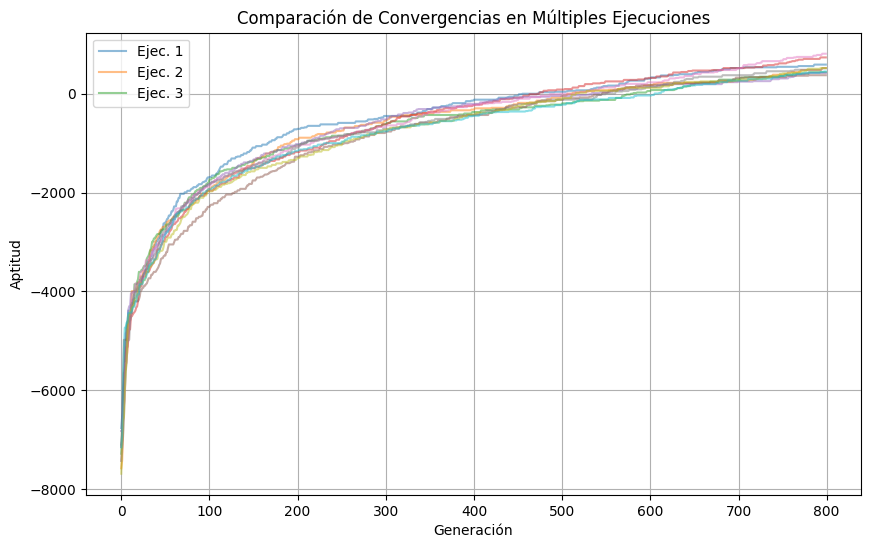

In [ ]:
# Ejecutar experimento
resultados6 = experimento_genetico(n_ejecuciones=10)

# 1. Obtener los 10 mejores horarios
top10_horarios6 = resultados6['mejores_horarios']
top10_aptitudes6 = resultados6['mejores_aptitudes']

# 2. Guardar el mejor absoluto
mejor_global_idx6 = np.argmax(top10_aptitudes6)
mejor_horario_global6 = top10_horarios[mejor_global_idx6]
print(f"\n★ Mejor horario global (aptitud: {top10_aptitudes6[mejor_global_idx6]:.2f}) ★")

# 3. Analizar resultados
analizar_resultados(resultados6)

In [ ]:
# 1. Obtener los 10 mejores horarios
top10_horarios6 = resultados6['mejores_horarios']
top10_aptitudes6 = resultados6['mejores_aptitudes']

# 2. Guardar el mejor absoluto
mejor_global_idx6 = np.argmax(top10_aptitudes6)
mejor_horario_global6 = top10_horarios[mejor_global_idx6]
print(f"\n★ Mejor horario global (aptitud: {top10_aptitudes6[mejor_global_idx6]:.2f}) ★")

# 1. Obtener los 10 mejores horarios
top10_horarios = resultados['mejores_horarios']
top10_aptitudes = resultados['mejores_aptitudes']

# 2. Guardar el mejor absoluto
mejor_global_idx = np.argmax(top10_aptitudes)
mejor_horario_global = top10_horarios[mejor_global_idx]
print(f"\n★ Mejor horario global (aptitud: {top10_aptitudes[mejor_global_idx]:.2f}) ★")




★ Mejor horario global (aptitud: 810.00) ★

★ Mejor horario global (aptitud: 1020.00) ★



=== Ejecución 1/10 ===
→ Aptitud: 780.00 | Convergencia: Gen 774 | Tiempo: 282.12s

=== Ejecución 2/10 ===
→ Aptitud: 1005.00 | Convergencia: Gen 793 | Tiempo: 281.88s

=== Ejecución 3/10 ===
→ Aptitud: 805.00 | Convergencia: Gen 796 | Tiempo: 280.90s

=== Ejecución 4/10 ===
→ Aptitud: 545.00 | Convergencia: Gen 797 | Tiempo: 280.06s

=== Ejecución 5/10 ===
→ Aptitud: 870.00 | Convergencia: Gen 788 | Tiempo: 281.68s

=== Ejecución 6/10 ===
→ Aptitud: 1020.00 | Convergencia: Gen 794 | Tiempo: 281.58s

=== Ejecución 7/10 ===
→ Aptitud: 950.00 | Convergencia: Gen 796 | Tiempo: 281.99s

=== Ejecución 8/10 ===
→ Aptitud: 910.00 | Convergencia: Gen 771 | Tiempo: 281.02s

=== Ejecución 9/10 ===
→ Aptitud: 635.00 | Convergencia: Gen 761 | Tiempo: 279.69s

=== Ejecución 10/10 ===
→ Aptitud: 900.00 | Convergencia: Gen 797 | Tiempo: 279.51s

★ Mejor horario global (aptitud: 1020.00) ★

=== RESUMEN ESTADÍSTICO ===
Mejor aptitud global: 1020.00
Aptitud promedio: 842.00 ± 146.62
Generaciones hasta 

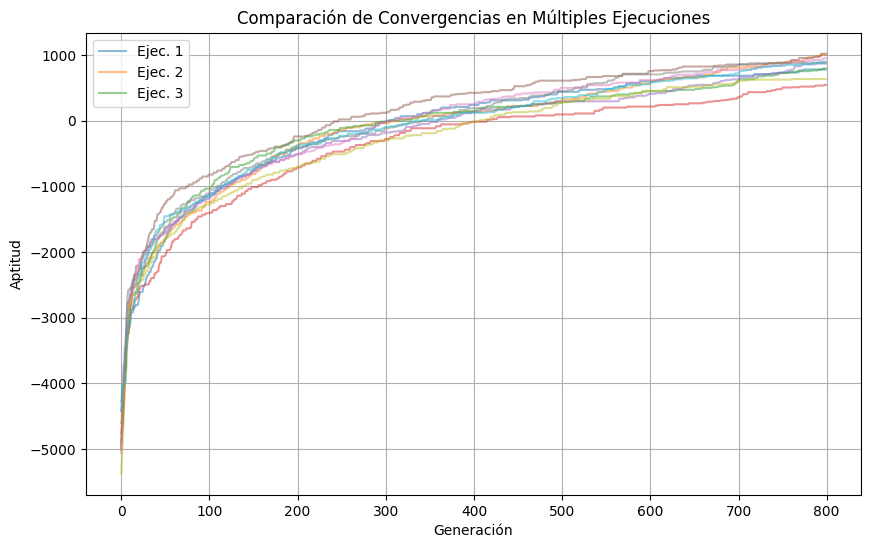

In [ ]:
# Ejecutar experimento
resultados = experimento_genetico(n_ejecuciones=10)

# 1. Obtener los 10 mejores horarios
top10_horarios = resultados['mejores_horarios']
top10_aptitudes = resultados['mejores_aptitudes']

# 2. Guardar el mejor absoluto
mejor_global_idx = np.argmax(top10_aptitudes)
mejor_horario_global = top10_horarios[mejor_global_idx]
print(f"\n★ Mejor horario global (aptitud: {top10_aptitudes[mejor_global_idx]:.2f}) ★")

# 3. Analizar resultados
analizar_resultados(resultados)

##Analisis 5 grupos

In [ ]:
# Analizar automáticamente los 10 horarios
df_analisis = analizar_resultados_completos(resultados)

# Mostrar resumen en consola
print("\n=== RESUMEN DE LAS 10 EJECUCIONES ===")
print(df_analisis.describe().loc[['mean', 'std', 'min', 'max']])

# Filtrar horarios válidos (sin conflictos)
horarios_validos = df_analisis[
    (df_analisis['Conflictos Profesores'] == 0) &
    (df_analisis['Conflictos Salones'] == 0)
]
print(f"\nHorarios completamente válidos: {len(horarios_validos)}/{len(df_analisis)}")


=== RESUMEN DE LAS 10 EJECUCIONES ===
      Ejecución     Aptitud  Conflictos Profesores  Conflictos Salones  \
mean    5.50000   842.00000                    0.0                 0.0   
std     3.02765   154.54593                    0.0                 0.0   
min     1.00000   545.00000                    0.0                 0.0   
max    10.00000  1020.00000                    0.0                 0.0   

      Horas Fuera de Rango  Materias Incompletas  Profesores Sin Asignar  \
mean             11.400000              4.400000                     0.0   
std               5.601587              1.776388                     0.0   
min               6.000000              3.000000                     0.0   
max              24.000000              8.000000                     0.0   

      Generación Convergencia  Tiempo Ejecución (s)  
mean               786.700000            281.044605  
std                 13.115301              0.978414  
min                761.000000            279.51

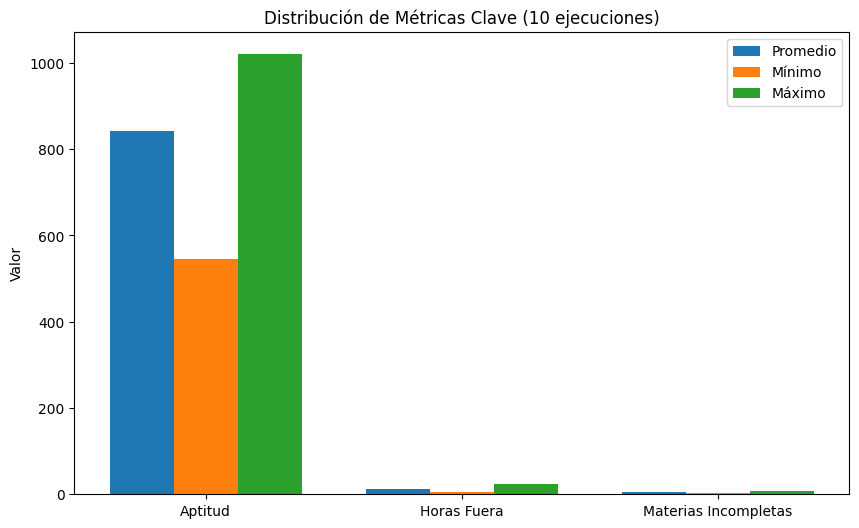

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo (reemplaza con tus datos reales)
metricas = ['Aptitud', 'Horas Fuera', 'Materias Incompletas']
valores_promedio = [842, 11.4, 4.4]
valores_min = [545, 6, 3]
valores_max = [1020, 24, 8]

x = np.arange(len(metricas))
width = 0.25

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width, valores_promedio, width, label='Promedio')
rects2 = ax.bar(x, valores_min, width, label='Mínimo')
rects3 = ax.bar(x + width, valores_max, width, label='Máximo')

ax.set_ylabel('Valor')
ax.set_title('Distribución de Métricas Clave (10 ejecuciones)')
ax.set_xticks(x)
ax.set_xticklabels(metricas)
ax.legend()

plt.savefig('resumen_metricas.png', dpi=300, bbox_inches='tight')

##Análisis 6 Grupos

In [ ]:
# Analizar automáticamente los 10 horarios
df_analisis = analizar_resultados_completos(resultados6)

# Mostrar resumen en consola
print("\n=== RESUMEN DE LAS 10 EJECUCIONES ===")
print(df_analisis.describe().loc[['mean', 'std', 'min', 'max']])

# Filtrar horarios válidos (sin conflictos)
horarios_validos = df_analisis[
    (df_analisis['Conflictos Profesores'] == 0) &
    (df_analisis['Conflictos Salones'] == 0)
]
print(f"\nHorarios completamente válidos: {len(horarios_validos)}/{len(df_analisis)}")


=== RESUMEN DE LAS 10 EJECUCIONES ===
      Ejecución     Aptitud  Conflictos Profesores  Conflictos Salones  \
mean    5.50000  537.000000                    0.0                 0.0   
std     3.02765  139.646379                    0.0                 0.0   
min     1.00000  375.000000                    0.0                 0.0   
max    10.00000  810.000000                    0.0                 0.0   

      Horas Fuera de Rango  Materias Incompletas  Profesores Sin Asignar  \
mean             20.700000               8.90000                     0.0   
std               3.743142               1.72884                     0.0   
min              15.000000               6.00000                     0.0   
max              27.000000              12.00000                     0.0   

      Generación Convergencia  Tiempo Ejecución (s)  
mean               789.500000            330.699004  
std                  6.964194              3.941101  
min                780.000000            325.66